In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from PIL import ImageDraw
from random import randint
from torchvision.models import resnet34, vgg16_bn, resnet50

In [3]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
path = Path('/home/jupyter/data/artwork2'); path.ls()

[PosixPath('/home/jupyter/data/artwork2/512'),
 PosixPath('/home/jupyter/data/artwork2/models'),
 PosixPath('/home/jupyter/data/artwork2/train_3'),
 PosixPath('/home/jupyter/data/artwork2/train_1.zip'),
 PosixPath('/home/jupyter/data/artwork2/train_2.zip'),
 PosixPath('/home/jupyter/data/artwork2/train_2'),
 PosixPath('/home/jupyter/data/artwork2/train_1'),
 PosixPath('/home/jupyter/data/artwork2/train_3.zip'),
 PosixPath('/home/jupyter/data/artwork2/images')]

In [5]:
path_img = path/'512'

In [6]:
fs = get_image_files(path_img, recurse=True); len(fs)

28029

In [7]:
size = 128
bs = 32
size, bs

(128, 32)

In [8]:
src = ImageImageList.from_folder(path_img).split_by_rand_pct(0.1)

In [9]:
class TfmPixelXOnly(TfmPixel):
    def __call__(self, *args, **kwargs):
        kwargs.pop('use_on_y', None)
        return super().__call__(*args, use_on_y=False, **kwargs)

In [10]:
def _draw_box(x):
    xy = x.shape[1:]
    bw, bh = randint(int(xy[0]*0.1), int(xy[0]*0.2)), randint(int(xy[1]*0.1), int(xy[1]*0.2))
    bx1, by1 = randint(0, xy[0]-bw), randint(0, xy[1]-bh)
    x[:, bx1:bx1+bh, by1:by1+bw] = 0
    return x

def _rand_boxes(x):
    for _ in range(randint(7, 13)): x = _draw_box(x)
    return x
rand_boxes = TfmPixelXOnly(_rand_boxes)

In [11]:
x_tfm, y_tfm = get_transforms(max_zoom=0.2)
y_tfm = x_tfm
x_tfm.append(rand_boxes())

In [12]:
data = (src
        .label_from_func(lambda x: x)
        .transform((x_tfm, x_tfm), tfm_y=True, size=size)
        .databunch(bs=bs).normalize(imagenet_stats, do_y=True)
       )

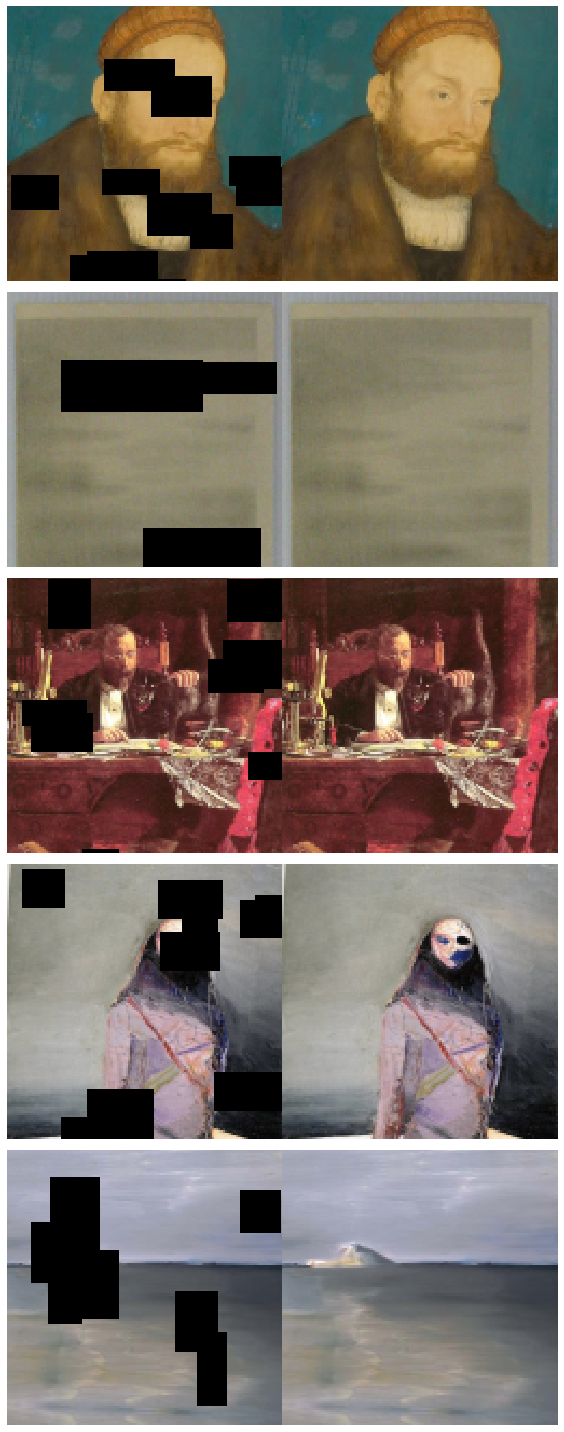

In [13]:
data.show_batch()

## Feature loss

In [14]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [15]:
base_loss = F.l1_loss

In [16]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layers, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = layers
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layers))
              ] + [f'gram_{i}' for i in range(len(layers))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [17]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [18]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
layers = [vgg_m[i] for i in blocks]

In [19]:
feat_loss = FeatureLoss(vgg_m, layers=layers[2:5], layer_wgts=[5, 15, 2])

## Train

In [20]:
learn = None
gc.collect()

22265

In [21]:
learn = unet_learner(data, models.resnet101, wd=1e-3, loss_func=feat_loss,
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Spectral,
                     self_attention=True, y_range=(-3, 3)).to_fp16()

In [26]:
learn.load('res50-vgg-stage-2-128_3')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


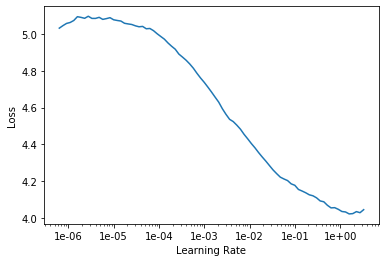

In [43]:
learn.lr_find()
learn.recorder.plot()

In [22]:
lr = 1e-2

In [45]:
learn.freeze()
learn.fit_one_cycle(1, lr, pct_start=0.8)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time


/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2618: DecompressionBombWarning: Image size (131790400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2618: DecompressionBombWarning: Image size (131790400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2618: DecompressionBombWarning: Image size (129097476 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2618: DecompressionBombWarning: Image size (129097476 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2618: DecompressionBombWarning: Image size (94435468 pixels) exc

DecompressionBombError: Caught DecompressionBombError in DataLoader worker process 7.
Original Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/anaconda3/lib/python3.7/site-packages/fastai/data_block.py", line 651, in __getitem__
    if self.item is None: x,y = self.x[idxs],self.y[idxs]
  File "/opt/anaconda3/lib/python3.7/site-packages/fastai/data_block.py", line 120, in __getitem__
    if isinstance(idxs, Integral): return self.get(idxs)
  File "/opt/anaconda3/lib/python3.7/site-packages/fastai/vision/data.py", line 271, in get
    res = self.open(fn)
  File "/opt/anaconda3/lib/python3.7/site-packages/fastai/vision/data.py", line 267, in open
    return open_image(fn, convert_mode=self.convert_mode, after_open=self.after_open)
  File "/opt/anaconda3/lib/python3.7/site-packages/fastai/vision/image.py", line 398, in open_image
    x = PIL.Image.open(fn).convert(convert_mode)
  File "/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py", line 2690, in open
    im = _open_core(fp, filename, prefix)
  File "/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py", line 2677, in _open_core
    _decompression_bomb_check(im.size)
  File "/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py", line 2611, in _decompression_bomb_check
    (pixels, 2 * MAX_IMAGE_PIXELS))
PIL.Image.DecompressionBombError: Image size (746700000 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.


In [46]:
learn.save('res101-128-stage1')

In [23]:
learn.load('res101-128-stage1')

Learner(data=ImageDataBunch;

Train: LabelList (25227 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /home/jupyter/data/artwork2/512;

Valid: LabelList (2802 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /home/jupyter/data/artwork2/512;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=Fal

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


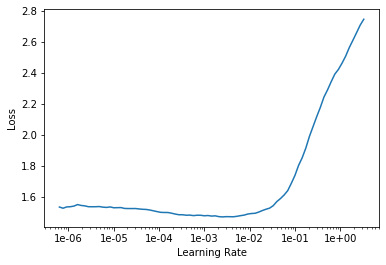

In [28]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [24]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(1e-5, 1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.335033,1.316885,0.101271,0.113666,0.169539,0.078361,0.234847,0.475831,0.143370,24:09


In [25]:
learn.save('res101-128-stage2')

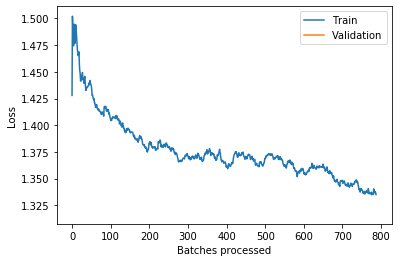

In [26]:
learn.recorder.plot_losses()

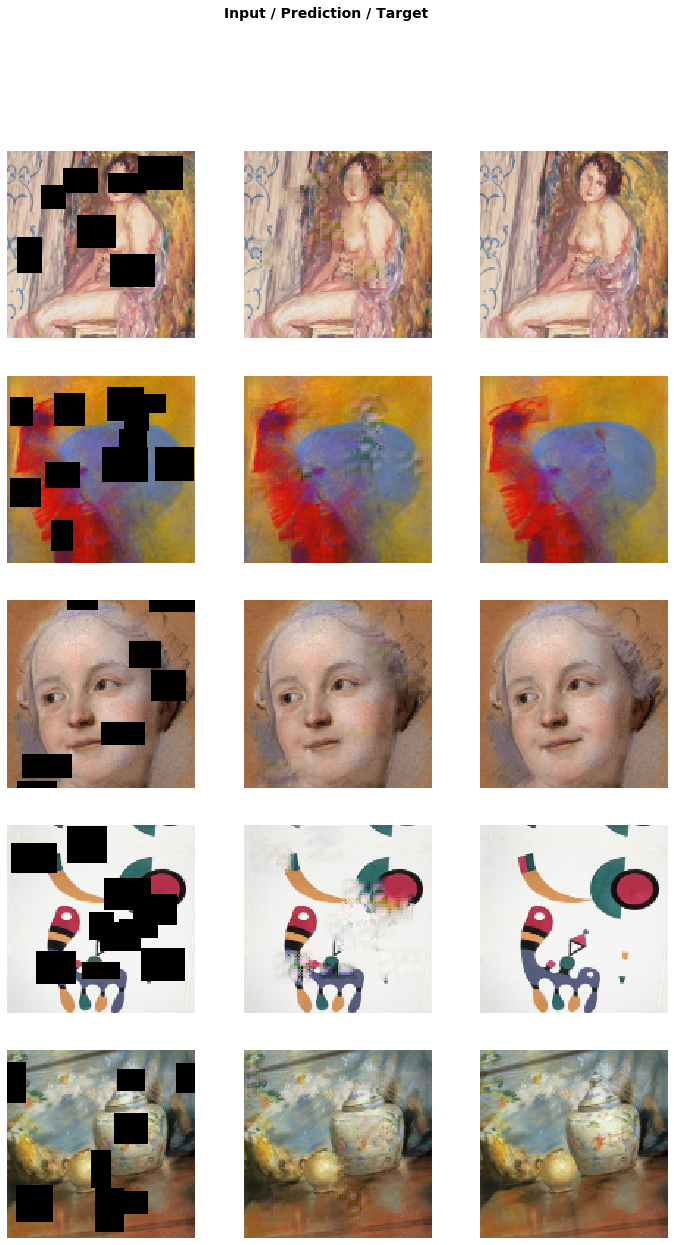

In [27]:
learn.show_results(ds_type=DatasetType.Valid)

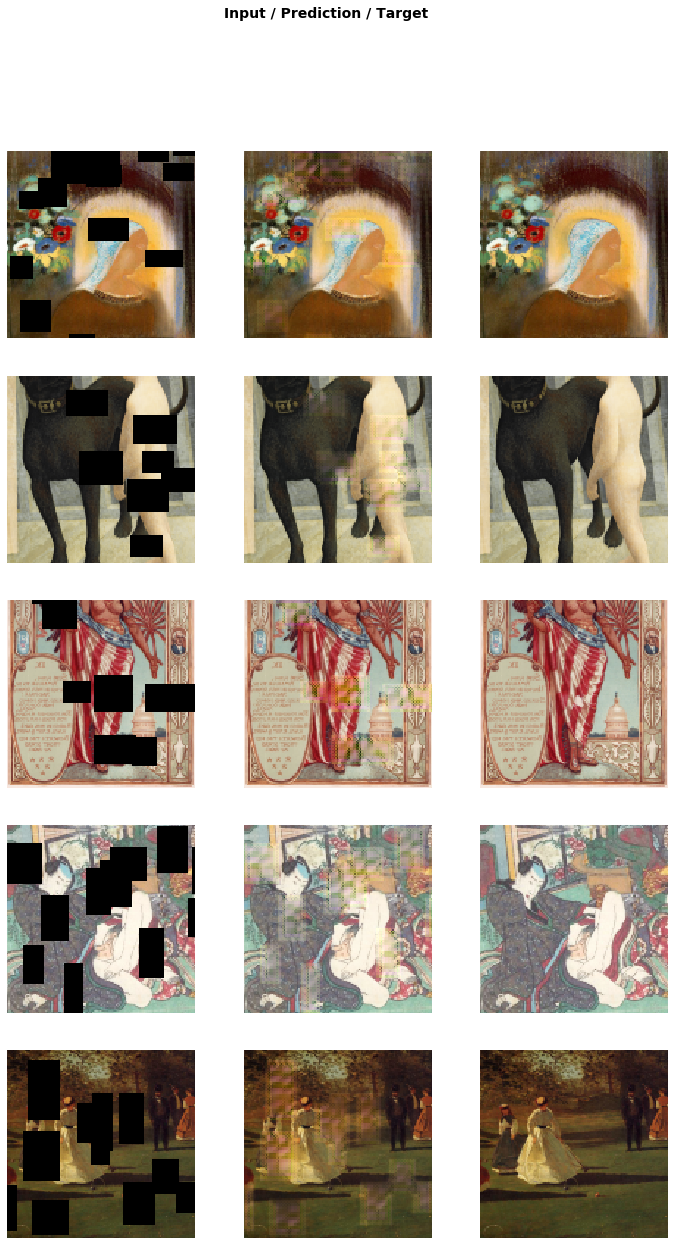

In [49]:
learn.show_results(ds_type=DatasetType.Train)